In [1]:
import pandas as pd
import numpy as np
import random
import sklearn
import matplotlib.pyplot as plt
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score, roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import itertools as it

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Cleaning

In [23]:
LABELS = ['Cannabinoid', 'Genetics', 'Intoxication', 'Look', 'Medical', 'Smell Flavor', 'Wellness', 'Commoditization']

In [24]:
def clean_data(df):
    df_clean = df.dropna()
    for label in LABELS:
        df_clean = df_clean[(df_clean[label] == 0) | (df_clean[label] == 1) | (df_clean[label] == '0') | (df_clean[label] == '1')]
        df_clean[label] = pd.to_numeric(df_clean[label])
    try:
        df_clean = df_clean.rename({'straindescription':'description'}, axis=1)
    except:
        print("The name of product description is already 'description'.")
    return df_clean

In [25]:
insample = pd.read_csv("data/in_sample.csv")
insample = clean_data(insample)
insample.to_csv('data/clean_in_sample.csv', index=False)
insample.head()

D:\miniconda3\envs\deep_wa\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,(first) scrape,ID#,description,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
0,101,2768,"""Anarchy OG"" Omega Beta Line --- Omega Concent...",1,0,0,0,0,0,0,1
1,101,3699,"""Blackberry Ogre"" Omega Gamma Line --- Omega C...",1,0,0,0,0,0,0,1
2,101,343,"""Blue Dream"" Green Rush --- Green Rush THC =...",1,0,0,0,0,0,1,0
3,101,14123,"""Blueberry"" Wax Omega Beta Line --- Omega Conc...",1,0,1,0,0,1,1,0
4,101,14031,"""Bubba Kush"" Phat Panda --- Phat Panda THC =...",1,1,0,0,0,0,0,0


In [27]:
# extra_insample = pd.read_csv("data/extra_in_sample.csv")
# extra_insample = extra_insample[['strain','Cannabinoid', 'Genetics', 'Intoxication', 'Medical', 'Smell Flavor', 'Wellness', 'Commoditization']]
# extra_insample = clean_data(extra_insample)
# extra_insample.to_csv('data/clean_extra_in_sample.csv', index=False)
# extra_insample.head()

In [28]:
outsample = pd.read_csv("data/out_sample.csv")
outsample = clean_data(outsample)
outsample.to_csv('data/clean_out_sample.csv', index=False)
outsample.head()

,ID#,description,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
0,3065,"""12th Man Down"" Phat Panda --- Phat Panda TH...",1,0,0,0,0,1,1,0
1,3799,"""Blue Dream"" Agrijuana --- THC = 23.70% \nBl...",1,1,1,0,0,0,1,0
2,2595,"""Blueberry Skunk"" Doc Croc --- Doc Croc THC ...",1,0,1,0,0,0,1,0
3,7651,"""Bubba Kush"" Doc Croc --- Doc Croc THC = 70....",1,0,0,0,0,0,0,1
4,4040,"""California Dreams"" Omega Concentrates Beta Li...",1,0,0,0,0,0,0,1


## Loading Clean Data

In [41]:
insample = pd.read_csv("data/clean_in_sample.csv")
insample.head()

,(first) scrape,ID#,description,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
0,101,2768,"""Anarchy OG"" Omega Beta Line --- Omega Concent...",1,0,0,0,0,0,0,1
1,101,3699,"""Blackberry Ogre"" Omega Gamma Line --- Omega C...",1,0,0,0,0,0,0,1
2,101,343,"""Blue Dream"" Green Rush --- Green Rush THC =...",1,0,0,0,0,0,1,0
3,101,14123,"""Blueberry"" Wax Omega Beta Line --- Omega Conc...",1,0,1,0,0,1,1,0
4,101,14031,"""Bubba Kush"" Phat Panda --- Phat Panda THC =...",1,1,0,0,0,0,0,0


In [42]:
outsample = pd.read_csv("data/clean_out_sample.csv")
outsample.head()

,ID#,description,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
0,3065,"""12th Man Down"" Phat Panda --- Phat Panda TH...",1,0,0,0,0,1,1,0
1,3799,"""Blue Dream"" Agrijuana --- THC = 23.70% \nBl...",1,1,1,0,0,0,1,0
2,2595,"""Blueberry Skunk"" Doc Croc --- Doc Croc THC ...",1,0,1,0,0,0,1,0
3,7651,"""Bubba Kush"" Doc Croc --- Doc Croc THC = 70....",1,0,0,0,0,0,0,1
4,4040,"""California Dreams"" Omega Concentrates Beta Li...",1,0,0,0,0,0,0,1


In [43]:
insample.describe()

,(first) scrape,ID#,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
count,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000
mean,197.581968,9130.183397,0.819021,0.305772,0.183947,0.094997,0.080154,0.246179,0.240022,0.484002
std,41.508437,4078.195382,0.385022,0.460759,0.387462,0.293227,0.271546,0.430808,0.427120,0.499771
min,101.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,154.000000,6444.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,215.000000,9697.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,227.000000,12321.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,245.000000,15215.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
outsample.describe()

,ID#,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
count,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000,5575.000000
mean,4855.755157,0.839283,0.224574,0.170045,0.093453,0.081794,0.225112,0.224574,0.572556
std,3616.448772,0.367303,0.417339,0.375706,0.291092,0.274075,0.417694,0.417339,0.494752
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2150.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4260.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,6485.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,15208.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Finding best model on In Sample Data

In [45]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen, dilation_rate=1):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters[2], kernel_size, activation='relu', dilation_rate=dilation_rate))
    model.add(layers.Conv1D(num_filters[1], kernel_size, activation='relu'))
    model.add(layers.Conv1D(num_filters[0], kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [46]:
param_grid = dict(num_filters=[[16, 32, 64], [32, 64, 128]],
                  kernel_size=[2, 3, 5],
                  vocab_size=[2000, 3000], 
                  embedding_dim=[20, 50, 100],
                  maxlen=[20, 40, 60])

In [47]:
colnames = ['model_name', 'pred_true', 'pred_false', 'actual_true', 'actual_false', 'accuracy',\
            'precision', 'recall', 'f1', 'sensitivity', 'specificity', 'informedness',\
            'matthews_correlation', 'cohen_kappa', 'roc_auc', 'tn', 'fp', 'fn', 'tp']

In [48]:
# Parameter grid for grid search
param_grid = dict(num_filters=[[16, 32, 64], [32, 64, 128], [64, 128, 256]],
            kernel_size=[2, 3], 
            dilation = [1, 2],
            vocab_size=[5000], 
            embedding_dim=[10, 20, 30],
            maxlen=[40, 60])

combinations = it.product(*(param_grid[key] for key in param_grid))
combinations = list(combinations)
len(combinations)

72

In [49]:
random.seed(1000)
num_combinations = 20
assert(num_combinations <= len(combinations))
sample_combinations = random.sample(combinations, k=num_combinations)
sample_combinations

[([64, 128, 256], 2, 2, 5000, 10, 40),
 ([16, 32, 64], 3, 1, 5000, 10, 40),
 ([64, 128, 256], 2, 1, 5000, 20, 40),
 ([32, 64, 128], 3, 2, 5000, 20, 60),
 ([16, 32, 64], 2, 2, 5000, 20, 40),
 ([64, 128, 256], 2, 2, 5000, 30, 60),
 ([16, 32, 64], 3, 2, 5000, 20, 60),
 ([64, 128, 256], 2, 2, 5000, 10, 60),
 ([16, 32, 64], 3, 1, 5000, 30, 40),
 ([16, 32, 64], 3, 1, 5000, 20, 40),
 ([32, 64, 128], 3, 2, 5000, 10, 40),
 ([16, 32, 64], 3, 1, 5000, 20, 60),
 ([16, 32, 64], 3, 2, 5000, 30, 60),
 ([32, 64, 128], 3, 2, 5000, 10, 60),
 ([32, 64, 128], 2, 2, 5000, 10, 60),
 ([64, 128, 256], 3, 2, 5000, 30, 40),
 ([64, 128, 256], 2, 2, 5000, 30, 40),
 ([64, 128, 256], 3, 1, 5000, 10, 60),
 ([64, 128, 256], 3, 2, 5000, 10, 40),
 ([64, 128, 256], 3, 1, 5000, 20, 40)]

In [50]:
def get_metrics(X, y, label, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen, vs):
    predictions = model.predict(X)
    predictions = predictions.round()

    metrics = {}

    metrics['pred_true'], metrics['pred_false'] = np.count_nonzero(predictions), predictions.shape[0] - np.count_nonzero(predictions)
    metrics['actual_true'], metrics['actual_false'] = np.count_nonzero(y), y.shape[0] - np.count_nonzero(y)
    metrics['accuracy'] = accuracy_score(y, predictions)
    metrics['precision'] = precision_score(y, predictions)
    metrics['recall'] = recall_score(y, predictions)
    metrics['f1'] = f1_score(y, predictions)

    metrics['matthews_correlation'] = matthews_corrcoef(y, predictions)
    metrics['cohen_kappa'] = cohen_kappa_score(y, predictions)
    metrics['roc_auc'] = roc_auc_score(y, predictions)    

    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
    metrics['specificity'] = tn / (tn+fp)
    metrics['sensitivity'] = tp / (tp+fn)
    metrics['informedness'] = metrics['specificity'] + metrics['sensitivity'] - 1

    metrics['tn'] = tn
    metrics['fp'] = fp
    metrics['fn'] = fn
    metrics['tp'] = tp

    metrics['num_filters'] = num_filters
    metrics['kernel_size'] = kernel_size
    metrics['dilation'] = dilation_rate
    metrics['vocab_size'] = vocab_size
    metrics['embedding_dim'] = embedding_dim
    metrics['maxlen'] = maxlen
    metrics['validation_set_size'] = vs

#     # Append to metrics file
#     cols['model_name'].append(label)
#     for metric, val in metrics.items():
#         cols[metric].append(val)
        
    return metrics

In [52]:
#validation set size
vs = 0.5

best_min_f1 = 0
best_hyperparameters = []

descriptions = insample['description']
descriptions_test = outsample['description']

colnames = ['model_name', 'pred_true', 'pred_false', 'actual_true', 'actual_false', 'accuracy',\
            'precision', 'recall', 'f1', 'sensitivity', 'specificity', 'informedness',\
            'matthews_correlation', 'cohen_kappa', 'roc_auc', 'tn', 'fp', 'fn', 'tp', 
               'num_filters', 'kernel_size', 'dilation', 'vocab_size', 'embedding_dim', 'maxlen', 'validation_set_size']

for c in sample_combinations:
    cols_val = {colname: [] for colname in colnames}
    cols_test = {colname: [] for colname in colnames}
    
    for label in LABELS:
        num_filters = c[0]
        kernel_size = c[1]
        dilation_rate = c[2]
        vocab_size = c[3]
        embedding_dim = c[4]
        maxlen = c[5]

        Y = insample[label]
        y_test = outsample[label]
        
        # Train-test split
        descriptions_train, descriptions_val, y_train, y_val = train_test_split(
            descriptions, Y, test_size=vs, random_state=1000)

        # Tokenize words
        tokenizer = Tokenizer(num_words=5000)
        tokenizer.fit_on_texts(descriptions_train)
        X_train = tokenizer.texts_to_sequences(descriptions_train)
        X_val = tokenizer.texts_to_sequences(descriptions_val)
        X_test = tokenizer.texts_to_sequences(descriptions_test)
        
        # Adding 1 because of reserved 0 index
        vocab_size = len(tokenizer.word_index) + 1

        # Pad sequences with zeros
        X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
        X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)  
        X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)  

        model = create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen, dilation_rate)

        es = EarlyStopping(monitor='val_acc', mode='max', min_delta=0.001, patience=2)
        model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    callbacks=[es])
        
        # Evaluate validation set
        metrics = get_metrics(X_val, y_val, label, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen, vs)
        # Append to validation metrics file
        cols_val['model_name'].append(label)
        for metric, val in metrics.items():
            cols_val[metric].append(val)
            
        # Evaluate testing set
        metrics = get_metrics(X_test, y_test, label, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen, vs)
        # Append to test metrics file
        cols_test['model_name'].append(label)
        for metric, val in metrics.items():
            cols_test[metric].append(val)

    traintestsplit = '{}.{}'.format(int(100-vs*100), int(vs*100))
    
    output = pd.DataFrame(cols_val)
    output = output[colnames]
    output.to_csv('./metrics/validation/metrics_traintestsplit({})_numfilters({})_kernelsize({})_dilation({})_vocab_size({})_embeddingdim({})_maxlen({}).csv'.format(traintestsplit, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen), index=False, quoting=csv.QUOTE_NONNUMERIC)
    
    output = pd.DataFrame(cols_test)
    output = output[colnames]
    output.to_csv('./metrics/test/metrics_traintestsplit({})_numfilters({})_kernelsize({})_dilation({})_vocab_size({})_embeddingdim({})_maxlen({}).csv'.format(traintestsplit, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen), index=False, quoting=csv.QUOTE_NONNUMERIC)

D:\miniconda3\envs\deep_wa\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\miniconda3\envs\deep_wa\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\miniconda3\envs\deep_wa\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\miniconda3\envs\deep_wa\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
D:\miniconda3\envs\deep_wa\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is il

## Best Models

In [16]:
from os import listdir
import seaborn as sns

In [17]:
def find_csv_filenames(path_to_dir, suffix=".csv"):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

### Best models on validation set

In [18]:
appended_data = []
filenames = find_csv_filenames("metrics/validation/")
for name in filenames:
    filename = "metrics/validation/" + name
    df = pd.read_csv(filename)
    appended_data.append(df)
validation_data = pd.concat(appended_data)
validation_data

,model_name,pred_true,pred_false,actual_true,actual_false,accuracy,precision,recall,f1,sensitivity,...,fp,fn,tp,num_filters,kernel_size,dilation,vocab_size,embedding_dim,maxlen,validation_set_size
0,Cannabinoid,2219,510,2244,485,0.925614,0.959892,0.949198,0.954515,0.949198,...,89,114,2130,"[64, 128, 256]",3,1,8292,10,60,0.3
1,Genetics,818,1911,849,1880,0.924148,0.892421,0.859835,0.875825,0.859835,...,88,119,730,"[64, 128, 256]",3,1,8292,10,60,0.3
2,Intoxication,0,2729,513,2216,0.812019,0.000000,0.000000,0.000000,0.000000,...,0,513,0,"[64, 128, 256]",3,1,8292,10,60,0.3
3,Look,0,2729,281,2448,0.897032,0.000000,0.000000,0.000000,0.000000,...,0,281,0,"[64, 128, 256]",3,1,8292,10,60,0.3
4,Medical,211,2518,232,2497,0.979113,0.914692,0.831897,0.871332,0.831897,...,18,39,193,"[64, 128, 256]",3,1,8292,10,60,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,Look,150,1669,193,1626,0.945574,0.813333,0.632124,0.711370,0.632124,...,28,71,122,"[64, 128, 256]",2,2,8758,10,40,0.2
4,Medical,0,1819,156,1663,0.914239,0.000000,0.000000,0.000000,0.000000,...,0,156,0,"[64, 128, 256]",2,2,8758,10,40,0.2
5,Smell Flavor,449,1370,468,1351,0.946674,0.913140,0.876068,0.894220,0.876068,...,39,58,410,"[64, 128, 256]",2,2,8758,10,40,0.2
6,Wellness,446,1373,455,1364,0.952172,0.912556,0.894505,0.903441,0.894505,...,39,48,407,"[64, 128, 256]",2,2,8758,10,40,0.2


In [19]:
validation_data.shape

(640, 26)

In [20]:
#change to display more/less best models
num_best_models = 1
appended_data = []
for label in LABELS:
    appended_data.append(validation_data[validation_data['model_name'] == label].sort_values(by='f1', ascending=False).iloc[:num_best_models])
best_models_validation = pd.concat(appended_data)
best_models_validation['rank'] = list(range(1,num_best_models+1)) * (int(len(best_models_validation) / num_best_models))
best_models_validation

,model_name,pred_true,pred_false,actual_true,actual_false,accuracy,precision,recall,f1,sensitivity,...,fn,tp,num_filters,kernel_size,dilation,vocab_size,embedding_dim,maxlen,validation_set_size,rank
0,Cannabinoid,1498,321,1504,315,0.934030,0.961949,0.958112,0.960027,0.958112,...,63,1441,"[64, 128, 256]",2,2,8758,30,60,0.2,1
1,Genetics,565,1254,571,1248,0.940627,0.909735,0.900175,0.904930,0.900175,...,57,514,"[16, 32, 64]",3,2,8758,30,60,0.2,1
2,Intoxication,324,1495,338,1481,0.965915,0.925926,0.887574,0.906344,0.887574,...,38,300,"[32, 64, 128]",3,2,8758,20,60,0.2,1
3,Look,186,1633,193,1626,0.958769,0.817204,0.787565,0.802111,0.787565,...,41,152,"[64, 128, 256]",3,1,8758,10,60,0.2,1
4,Medical,146,1673,156,1663,0.982408,0.924658,0.865385,0.894040,0.865385,...,21,135,"[16, 32, 64]",3,2,8758,30,60,0.2,1
5,Smell Flavor,885,2753,912,2726,0.961242,0.935593,0.907895,0.921536,0.907895,...,84,828,"[16, 32, 64]",3,1,7789,20,60,0.4,1
6,Wellness,457,1362,455,1364,0.964816,0.927790,0.931868,0.929825,0.931868,...,31,424,"[16, 32, 64]",3,1,8758,20,60,0.2,1
7,Commoditization,1340,1389,1319,1410,0.943203,0.934328,0.949204,0.941707,0.949204,...,67,1252,"[16, 32, 64]",3,1,8292,20,60,0.3,1


In [21]:
best_models_validation[['model_name' , 'num_filters', 'kernel_size', 
                        'dilation', 'vocab_size', 'embedding_dim', 
                        'maxlen', 'validation_set_size']].to_csv('./metrics/best_validation_model_hyperparameters.csv', index=False)

In [22]:
best_models_validation[['num_filters', 'kernel_size', 'dilation', 'vocab_size','embedding_dim', 'maxlen', 'validation_set_size']].mode()

,num_filters,kernel_size,dilation,vocab_size,embedding_dim,maxlen,validation_set_size
0,"[16, 32, 64]",3.0,1,8758.0,20.0,60.0,0.2
1,NaN,NaN,2,NaN,NaN,NaN,NaN


In [23]:
best_models_validation[['num_filters', 'kernel_size', 'dilation', 'vocab_size','embedding_dim', 'maxlen', 'validation_set_size']].describe()

,kernel_size,dilation,vocab_size,embedding_dim,maxlen,validation_set_size
count,8.000000,8.000000,8.000000,8.000000,8.0,8.000000
mean,2.875000,1.500000,8578.625000,22.500000,60.0,0.237500
std,0.353553,0.534522,358.312289,7.071068,0.0,0.074402
min,2.000000,1.000000,7789.000000,10.000000,60.0,0.200000
25%,3.000000,1.000000,8641.500000,20.000000,60.0,0.200000
50%,3.000000,1.500000,8758.000000,20.000000,60.0,0.200000
75%,3.000000,2.000000,8758.000000,30.000000,60.0,0.225000
max,3.000000,2.000000,8758.000000,30.000000,60.0,0.400000


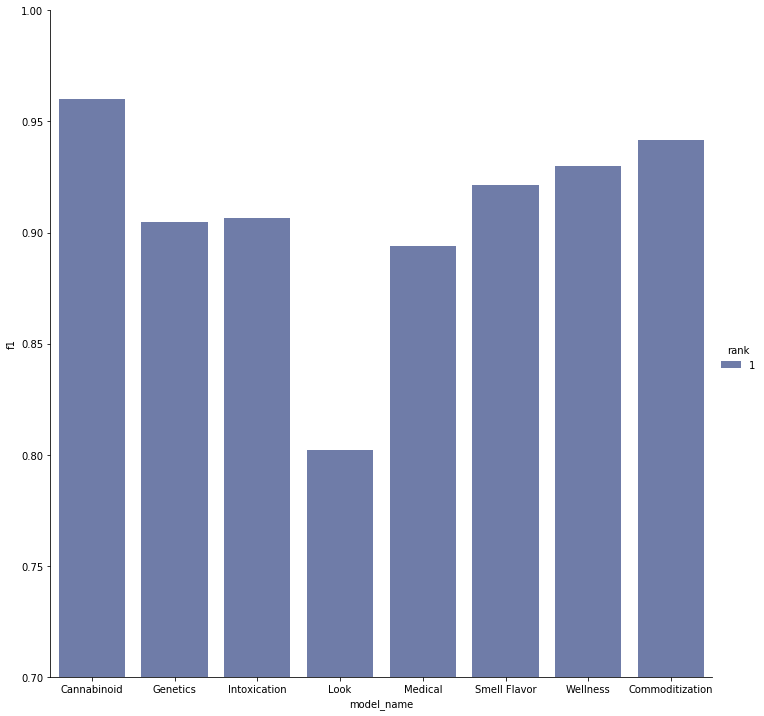

In [24]:
g = sns.catplot(
    data=best_models_validation, kind="bar",
    x="model_name", y="f1", hue="rank",
    ci="sd", palette="dark", alpha=.6, height=10
)
g.set(ylim=(0.7, 1))

### Best Models on test set

In [25]:
appended_data = []
filenames = find_csv_filenames("metrics/test/")
for name in filenames:
    filename = "metrics/test/" + name
    df = pd.read_csv(filename)
    appended_data.append(df)
test_data = pd.concat(appended_data)
test_data

,model_name,pred_true,pred_false,actual_true,actual_false,accuracy,precision,recall,f1,sensitivity,...,fp,fn,tp,num_filters,kernel_size,dilation,vocab_size,embedding_dim,maxlen,validation_set_size
0,Cannabinoid,4633,942,4679,896,0.929686,0.962659,0.953195,0.957904,0.953195,...,173,219,4460,"[64, 128, 256]",3,1,8292,10,60,0.3
1,Genetics,1256,4319,1252,4323,0.944395,0.875000,0.877796,0.876396,0.877796,...,157,153,1099,"[64, 128, 256]",3,1,8292,10,60,0.3
2,Intoxication,0,5575,948,4627,0.829955,0.000000,0.000000,0.000000,0.000000,...,0,948,0,"[64, 128, 256]",3,1,8292,10,60,0.3
3,Look,0,5575,521,5054,0.906547,0.000000,0.000000,0.000000,0.000000,...,0,521,0,"[64, 128, 256]",3,1,8292,10,60,0.3
4,Medical,416,5159,456,5119,0.984215,0.942308,0.859649,0.899083,0.859649,...,24,64,392,"[64, 128, 256]",3,1,8292,10,60,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,Look,389,5186,521,5054,0.950493,0.814910,0.608445,0.696703,0.608445,...,72,204,317,"[64, 128, 256]",2,2,8758,10,40,0.2
4,Medical,0,5575,456,5119,0.918206,0.000000,0.000000,0.000000,0.000000,...,0,456,0,"[64, 128, 256]",2,2,8758,10,40,0.2
5,Smell Flavor,1204,4371,1255,4320,0.950314,0.906146,0.869323,0.887353,0.869323,...,113,164,1091,"[64, 128, 256]",2,2,8758,10,40,0.2
6,Wellness,1249,4326,1252,4323,0.952466,0.895116,0.892971,0.894042,0.892971,...,131,134,1118,"[64, 128, 256]",2,2,8758,10,40,0.2


In [26]:
test_data.shape

(640, 26)

In [27]:
#change to display more/less best models
num_best_models = 1
appended_data = []
for label in LABELS:
    appended_data.append(test_data[test_data['model_name'] == label].sort_values(by='f1', ascending=False).iloc[:num_best_models])
best_models_test = pd.concat(appended_data)
best_models_test['rank'] = list(range(1,num_best_models+1)) * (int(len(best_models_test) / num_best_models))
best_models_test

,model_name,pred_true,pred_false,actual_true,actual_false,accuracy,precision,recall,f1,sensitivity,...,fn,tp,num_filters,kernel_size,dilation,vocab_size,embedding_dim,maxlen,validation_set_size,rank
0,Cannabinoid,4682,893,4679,896,0.934888,0.960914,0.961530,0.961222,0.961530,...,180,4499,"[64, 128, 256]",2,2,8758,30,60,0.2,1
1,Genetics,1260,4315,1252,4323,0.950493,0.887302,0.892971,0.890127,0.892971,...,134,1118,"[16, 32, 64]",3,2,8758,30,60,0.2,1
2,Intoxication,894,4681,948,4627,0.963408,0.916107,0.863924,0.889251,0.863924,...,129,819,"[32, 64, 128]",3,2,8758,20,60,0.2,1
3,Look,493,5082,521,5054,0.963408,0.821501,0.777351,0.798817,0.777351,...,116,405,"[64, 128, 256]",3,1,8758,10,60,0.2,1
4,Medical,428,5147,456,5119,0.984933,0.934579,0.877193,0.904977,0.877193,...,56,400,"[16, 32, 64]",3,2,8758,30,60,0.2,1
5,Smell Flavor,1298,4277,1255,4320,0.962870,0.903698,0.934661,0.918919,0.934661,...,82,1173,"[32, 64, 128]",3,2,7789,10,60,0.4,1
6,Wellness,1304,4271,1252,4323,0.960179,0.894939,0.932109,0.913146,0.932109,...,85,1167,"[16, 32, 64]",3,1,8758,20,60,0.2,1
7,Commoditization,3165,2410,3192,2383,0.953184,0.963033,0.954887,0.958943,0.954887,...,144,3048,"[16, 32, 64]",3,1,8758,20,60,0.2,1


In [28]:
best_models_test[['model_name' , 'num_filters', 'kernel_size', 
                        'dilation', 'vocab_size', 'embedding_dim', 
                        'maxlen', 'validation_set_size']].to_csv('./metrics/best_test_model_hyperparameters.csv', index=False)

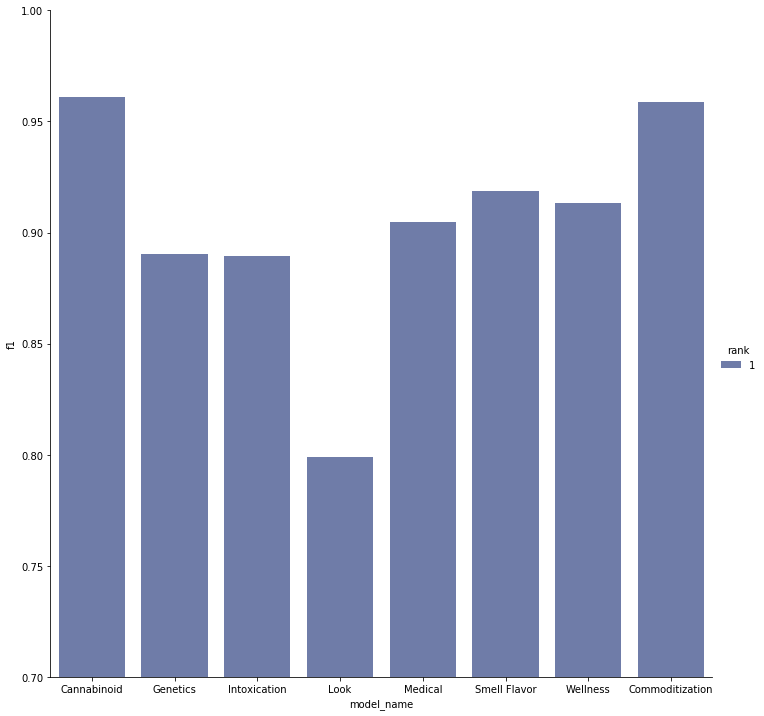

In [29]:
g = sns.catplot(
    data=best_models_test, kind="bar",
    x="model_name", y="f1", hue="rank",
    ci="sd", palette="dark", alpha=.6, height=10
)
g.set(ylim=(0.7, 1))

## Predictions

In [30]:
full_dataset = pd.read_csv("data/full_dataset.csv")
full_dataset.head()

/Users/nabeel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (9,19,28,29,30,31,32,33,34,35,36,37,42,43,46,47,48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,v1,address,city,description,email,price_ounce,product_id,published,scrape_number,slug,...,thc,test_expires,has_photo,photo_filename,pageviews,ratecnt,dateupdated,delivery,rec,v39
0,2651.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.9%-24.9% THC Shake.,recreational365@yahoo.com,65.0,31511407,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2652.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.4%-24.4% THC,recreational365@yahoo.com,0.0,31457256,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2653.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,30833338,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2654.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,14.0%-18.0% THC,recreational365@yahoo.com,210.0,31453769,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2655.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,28199355,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
full_dataset.shape

(459287, 50)

In [30]:
full_dataset.dropna(subset=['description'], inplace=True)
full_dataset.shape

(338889, 50)

In [32]:
full_dataset['new_description'] = '"' + full_dataset['strain'].astype(str) + '" -- '+ full_dataset['description'].astype(str)

In [33]:
full_dataset.head()

,v1,address,city,description,email,price_ounce,product_id,published,scrape_number,slug,...,test_expires,has_photo,photo_filename,pageviews,ratecnt,dateupdated,delivery,rec,v39,new_description
0,2651.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.9%-24.9% THC Shake.,recreational365@yahoo.com,65.0,31511407,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Purple Punch by Hempkings"" -- 20.9%-24.9% THC..."
1,2652.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.4%-24.4% THC,recreational365@yahoo.com,0.0,31457256,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Terpee Slurpee by Phat Panda"" -- 20.4%-24.4% THC"
2,2653.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,30833338,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Candied Grapes by Creekside Cannabis"" -- 18.0..."
3,2654.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,14.0%-18.0% THC,recreational365@yahoo.com,210.0,31453769,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Blue Steel by Top Shelf"" -- 14.0%-18.0% THC"
4,2655.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,28199355,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Alien Candy by Green Island Growers"" -- 18.0%..."


In [34]:
LABELS = ['Medical', 'Cannabinoid', 'Genetics', 'Intoxication', 'Wellness', 'Commoditization','Smell Flavor', 'Look']

In [35]:
appended_data = []
filenames = find_csv_filenames("metrics/validation/")
for name in filenames:
    filename = "metrics/validation/" + name
    df = pd.read_csv(filename)
    appended_data.append(df)
validation_data = pd.concat(appended_data)

num_best_models = 1
appended_data = []
for label in LABELS:
    appended_data.append(validation_data[validation_data['model_name'] == label].sort_values(by='f1', ascending=False).iloc[:num_best_models])
best_models_validation = pd.concat(appended_data)
best_models_validation['rank'] = list(range(1,num_best_models+1)) * (int(len(best_models_validation) / num_best_models))
best_models_validation

,model_name,pred_true,pred_false,actual_true,actual_false,accuracy,precision,recall,f1,sensitivity,...,fn,tp,num_filters,kernel_size,dilation,vocab_size,embedding_dim,maxlen,validation_set_size,rank
4,Medical,146,1673,156,1663,0.982408,0.924658,0.865385,0.894040,0.865385,...,21,135,"[16, 32, 64]",3,2,8758,30,60,0.2,1
0,Cannabinoid,1498,321,1504,315,0.934030,0.961949,0.958112,0.960027,0.958112,...,63,1441,"[64, 128, 256]",2,2,8758,30,60,0.2,1
1,Genetics,565,1254,571,1248,0.940627,0.909735,0.900175,0.904930,0.900175,...,57,514,"[16, 32, 64]",3,2,8758,30,60,0.2,1
2,Intoxication,324,1495,338,1481,0.965915,0.925926,0.887574,0.906344,0.887574,...,38,300,"[32, 64, 128]",3,2,8758,20,60,0.2,1
6,Wellness,457,1362,455,1364,0.964816,0.927790,0.931868,0.929825,0.931868,...,31,424,"[16, 32, 64]",3,1,8758,20,60,0.2,1
7,Commoditization,1340,1389,1319,1410,0.943203,0.934328,0.949204,0.941707,0.949204,...,67,1252,"[16, 32, 64]",3,1,8292,20,60,0.3,1
5,Smell Flavor,885,2753,912,2726,0.961242,0.935593,0.907895,0.921536,0.907895,...,84,828,"[16, 32, 64]",3,1,7789,20,60,0.4,1
3,Look,186,1633,193,1626,0.958769,0.817204,0.787565,0.802111,0.787565,...,41,152,"[64, 128, 256]",3,1,8758,10,60,0.2,1


In [36]:
insample.shape[0] + outsample.shape[0]

14670

In [37]:
merged_insample_outsample = pd.concat([insample, outsample], axis=0)
merged_insample_outsample.head()

,Unnamed: 0,description,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
0,0,"""Anarchy OG"" Omega Beta Line --- Omega Concent...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,"""Blackberry Ogre"" Omega Gamma Line --- Omega C...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,"""Blue Dream"" Green Rush --- Green Rush THC = 2...",1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,"""Blueberry"" Wax Omega Beta Line --- Omega Conc...",1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,4,"""Bubba Kush"" Phat Panda --- Phat Panda THC = 1...",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
merged_insample_outsample.describe()

,Unnamed: 0,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
count,14670.000000,14670.000000,14670.000000,14670.000000,14670.000000,14670.000000,14670.000000,14670.000000,14670.000000
mean,3879.135515,0.826721,0.274915,0.178664,0.094410,0.080777,0.238173,0.234151,0.517655
std,2447.400988,0.378501,0.446487,0.383084,0.292409,0.272502,0.425980,0.423482,0.499705
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1834.250000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3668.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5502.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9095.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
descriptions = insample['description']
# descriptions_test = predictions_df['new_description']
descriptions_test = full_dataset['new_description']
preds_dict = {}

for index, row in best_models_validation.iterrows():
    label = row['model_name']
    num_filters = row['num_filters'].strip('][').split(', ')
    num_filters = [int(i) for i in num_filters]
    kernel_size = int(row['kernel_size'])
    dilation_rate = int(row['dilation'])
    vocab_size = 5000
    embedding_dim = int(row['embedding_dim'])
    maxlen = int(row['maxlen'])
    vs = float(row['validation_set_size'])

    print(label)    
    Y = insample[label]
#     y_test = outsample[label]

    # Train-test split
    descriptions_train, descriptions_val, y_train, y_val = train_test_split(
        descriptions, Y, test_size=vs, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(descriptions_train)
    X_train = tokenizer.texts_to_sequences(descriptions_train)
    X_val = tokenizer.texts_to_sequences(descriptions_val)
    X_test = tokenizer.texts_to_sequences(descriptions_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)  
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)  

    model = create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen, dilation_rate)

    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=2)
    model.fit(X_train, y_train,
                epochs=20,
                verbose=False,
                batch_size=256,
                validation_data=(X_val, y_val),
                callbacks=[es])

    # Evaluate testing set
    predictions = model.predict(X_test)
    predictions = predictions.round()
    
    preds_dict[label] = predictions
#     predictions_df[label] = predictions
#     full_dataset[label] = predictions

Medical
Cannabinoid
Genetics
Intoxication
Wellness
Commoditization
Smell Flavor
Look


In [40]:
for label in preds_dict:
    print(label)
    print(np.mean(preds_dict[label]))
    print(np.std(preds_dict[label]))
    print(len(preds_dict[label]))
    print()

Medical
0.0
0.0
459287

Cannabinoid
0.687766
0.4634047
459287

Genetics
0.054142617
0.22629891
459287

Intoxication
0.05108135
0.22016364
459287

Wellness
0.033980932
0.1811801
459287

Commoditization
0.7977082
0.40170863
459287

Smell Flavor
0.0
0.0
459287

Look
0.017054696
0.1294752
459287



In [41]:
insample.describe()

,Unnamed: 0,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
count,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000,9095.000000
mean,4547.847828,0.819021,0.305772,0.183947,0.094997,0.080154,0.246179,0.240022,0.484002
std,2625.868171,0.385022,0.460759,0.387462,0.293227,0.271546,0.430808,0.427120,0.499771
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2274.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4548.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6821.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9095.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
insample_medical = insample[['description', 'Medical']]
insample_medical.head()

,description,Medical
0,"""Anarchy OG"" Omega Beta Line --- Omega Concent...",0.0
1,"""Blackberry Ogre"" Omega Gamma Line --- Omega C...",0.0
2,"""Blue Dream"" Green Rush --- Green Rush THC = 2...",0.0
3,"""Blueberry"" Wax Omega Beta Line --- Omega Conc...",0.0
4,"""Bubba Kush"" Phat Panda --- Phat Panda THC = 1...",0.0


In [43]:
insample_medical.describe()

,Medical
count,9095.000000
mean,0.080154
std,0.271546
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [44]:
class_0_medical = insample_medical[insample_medical['Medical'] == 0]
class_1_medical = insample_medical[insample_medical['Medical'] == 1]
print(class_0_medical.shape[0])
print(class_1_medical.shape[0])

8366
729


In [45]:
class_count_1 = 729 #we want to make medical 50% of our new sample
class_0_under = class_0_medical.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1_medical], axis=0)
test_under

,description,Medical
5343,Mango Haze Cbd by Dream City --- 6.1% THC 7.2%...,0.0
6938,Quantum Kush --- From Dope Cup winning grower ...,0.0
5862,Nova Dia God Bud 3.5g --- 19.4% THC 0.3% CBD,0.0
619,Artizen: BHO Dutchberry --- Cake Icing Total: ...,0.0
1117,Blue Dream C by Green Chiefs --- 19.2%-23.2% T...,0.0
...,...,...
9053,Yummy Cbd by Dream City --- 0.9% THC 14.8% CBD...,1.0
9054,Yummy Cbd by Dream City --- 5.7% THC 14.4% CBD...,1.0
9057,ZKittlez Cartridge 1g --- 85.2% THC An indica ...,1.0
9059,Zensation --- Indica 75/25 Zensation belongs t...,1.0


In [46]:
test_under.describe()

,Medical
count,1458.000000
mean,0.500000
std,0.500172
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [47]:
# retraining just for medical label
descriptions = test_under['description']
# descriptions_test = predictions_df['new_description']
descriptions_test = full_dataset['new_description']
# preds_dict = {}

best_f1 = 0

for c in sample_combinations:
    cols_val = {colname: [] for colname in colnames}
    cols_test = {colname: [] for colname in colnames}
    
    for vs in [0.2]:
        num_filters = c[0]
        kernel_size = c[1]
        dilation_rate = c[2]
        vocab_size = c[3]
        embedding_dim = c[4]
        maxlen = c[5]

        for index, row in best_models_validation.iterrows():
            label = row['model_name']
            if label == 'Medical':
#                 num_filters = row['num_filters'].strip('][').split(', ')
#                 num_filters = [int(i) for i in num_filters]
#                 kernel_size = int(row['kernel_size'])
#                 dilation_rate = int(row['dilation'])
#                 vocab_size = 5000
#                 embedding_dim = int(row['embedding_dim'])
#                 maxlen = int(row['maxlen'])
                
#                 num_filters = c[0]
#                 kernel_size = c[1]
#                 dilation_rate = c[2]
#                 vocab_size = c[3]
#                 embedding_dim = c[4]
#                 maxlen = c[5]

                print(label)    
                Y = test_under[label]
            #     y_test = outsample[label]

                # Train-test split
                descriptions_train, descriptions_val, y_train, y_val = train_test_split(
                    descriptions, Y, test_size=vs, random_state=1000)

                # Tokenize words
                tokenizer = Tokenizer(num_words=5000)
                tokenizer.fit_on_texts(descriptions_train)
                X_train = tokenizer.texts_to_sequences(descriptions_train)
                X_val = tokenizer.texts_to_sequences(descriptions_val)
                X_test = tokenizer.texts_to_sequences(descriptions_test)

                # Adding 1 because of reserved 0 index
                vocab_size = len(tokenizer.word_index) + 1

                # Pad sequences with zeros
                X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
                X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)  
                X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)  

                model = create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen, dilation_rate)

        #         es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=2)
                model.fit(X_train, y_train,
                            epochs=15,
                            verbose=True,
                            batch_size=256,
                            validation_data=(X_val, y_val)
                         )

                # Evaluate validation set
                metrics = get_metrics(X_val, y_val, label, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen, vs)
                
#                 # Append to validation metrics file
#                 cols_val['model_name'].append(label)
#                 for metric, val in metrics.items():
#                     print(cols_val)
#                     cols_val[metric].append(val)
                
                if metrics['f1'] > best_f1:
                    
                    # Evaluate testing set
                    predictions = model.predict(X_test)
                    predictions = predictions.round()

                    preds_dict[label + '_undersampled'] = predictions
                #     predictions_df[label] = predictions
                #     full_dataset[label] = predictions
                    best_f1 = metrics['f1']
                    best_metrics = metrics

#                 # Evaluate testing set
#                 metrics = get_metrics(X_test, y_test, label, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen, vs)
#                 # Append to test metrics file
#                 cols_test['model_name'].append(label)
#                 for metric, val in metrics.items():
#                     cols_test[metric].append(val)
                
                

#             traintestsplit = '{}.{}'.format(int(100-vs*100), int(vs*100))

#             output = pd.DataFrame(cols_val)
#             output = output[colnames]
#             output.to_csv('./metrics/validation/metrics_traintestsplit({})_numfilters({})_kernelsize({})_dilation({})_vocab_size({})_embeddingdim({})_maxlen({}).csv'.format(traintestsplit, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen), index=False, quoting=csv.QUOTE_NONNUMERIC)

#             output = pd.DataFrame(cols_test)
#             output = output[colnames]
#             output.to_csv('./metrics/test/metrics_traintestsplit({})_numfilters({})_kernelsize({})_dilation({})_vocab_size({})_embeddingdim({})_maxlen({}).csv'.format(traintestsplit, num_filters, kernel_size, dilation_rate, vocab_size, embedding_dim, maxlen), index=False, quoting=csv.QUOTE_NONNUMERIC)
best_metrics     

Medical
Train on 1166 samples, validate on 292 samples
Epoch 1/15
1166/1166 [==============================] - 1s 766us/step - loss: 0.6917 - accuracy: 0.6690 - val_loss: 0.6853 - val_accuracy: 0.8322
Epoch 2/15
1166/1166 [==============================] - 0s 305us/step - loss: 0.6792 - accuracy: 0.8413 - val_loss: 0.6636 - val_accuracy: 0.8767
Epoch 3/15
1166/1166 [==============================] - 0s 297us/step - loss: 0.6479 - accuracy: 0.8705 - val_loss: 0.6129 - val_accuracy: 0.8733
Epoch 4/15
1166/1166 [==============================] - 0s 305us/step - loss: 0.5832 - accuracy: 0.8696 - val_loss: 0.5171 - val_accuracy: 0.8733
Epoch 5/15
1166/1166 [==============================] - 0s 369us/step - loss: 0.4653 - accuracy: 0.8705 - val_loss: 0.3955 - val_accuracy: 0.8767
Epoch 6/15
1166/1166 [==============================] - 0s 308us/step - loss: 0.3283 - accuracy: 0.8782 - val_loss: 0.3165 - val_accuracy: 0.8870
Epoch 7/15
1166/1166 [==============================] - 0s 290us/step

1166/1166 [==============================] - 0s 252us/step - loss: 0.1546 - accuracy: 0.9357 - val_loss: 0.2132 - val_accuracy: 0.8973
Epoch 11/15
1166/1166 [==============================] - 0s 246us/step - loss: 0.1087 - accuracy: 0.9537 - val_loss: 0.1872 - val_accuracy: 0.9281
Epoch 12/15
1166/1166 [==============================] - 0s 252us/step - loss: 0.0728 - accuracy: 0.9734 - val_loss: 0.1582 - val_accuracy: 0.9315
Epoch 13/15
1166/1166 [==============================] - 0s 244us/step - loss: 0.0479 - accuracy: 0.9854 - val_loss: 0.1635 - val_accuracy: 0.9418
Epoch 14/15
1166/1166 [==============================] - 0s 254us/step - loss: 0.0355 - accuracy: 0.9897 - val_loss: 0.1517 - val_accuracy: 0.9452
Epoch 15/15
1166/1166 [==============================] - 0s 246us/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.1542 - val_accuracy: 0.9452
Medical
Train on 1166 samples, validate on 292 samples
Epoch 1/15
1166/1166 [==============================] - 1s 628us/step - los

1166/1166 [==============================] - 0s 400us/step - loss: 0.5267 - accuracy: 0.8628 - val_loss: 0.4776 - val_accuracy: 0.8596
Epoch 5/15
1166/1166 [==============================] - 0s 403us/step - loss: 0.4232 - accuracy: 0.8654 - val_loss: 0.3935 - val_accuracy: 0.8596
Epoch 6/15
1166/1166 [==============================] - 0s 408us/step - loss: 0.3501 - accuracy: 0.8688 - val_loss: 0.3440 - val_accuracy: 0.8562
Epoch 7/15
1166/1166 [==============================] - 0s 417us/step - loss: 0.3004 - accuracy: 0.8705 - val_loss: 0.3157 - val_accuracy: 0.8562
Epoch 8/15
1166/1166 [==============================] - 0s 394us/step - loss: 0.2522 - accuracy: 0.8791 - val_loss: 0.2724 - val_accuracy: 0.8699
Epoch 9/15
1166/1166 [==============================] - 0s 401us/step - loss: 0.1939 - accuracy: 0.9108 - val_loss: 0.2269 - val_accuracy: 0.8973
Epoch 10/15
1166/1166 [==============================] - 0s 422us/step - loss: 0.1392 - accuracy: 0.9451 - val_loss: 0.1930 - val_accur

1166/1166 [==============================] - 0s 147us/step - loss: 0.0249 - accuracy: 0.9931 - val_loss: 0.2395 - val_accuracy: 0.9247
Epoch 15/15
1166/1166 [==============================] - 0s 153us/step - loss: 0.0205 - accuracy: 0.9940 - val_loss: 0.2620 - val_accuracy: 0.9247
Medical
Train on 1166 samples, validate on 292 samples
Epoch 1/15
1166/1166 [==============================] - 1s 782us/step - loss: 0.6904 - accuracy: 0.5789 - val_loss: 0.6857 - val_accuracy: 0.8733
Epoch 2/15
1166/1166 [==============================] - 0s 108us/step - loss: 0.6823 - accuracy: 0.8877 - val_loss: 0.6766 - val_accuracy: 0.8870
Epoch 3/15
1166/1166 [==============================] - 0s 123us/step - loss: 0.6701 - accuracy: 0.9022 - val_loss: 0.6616 - val_accuracy: 0.8801
Epoch 4/15
1166/1166 [==============================] - 0s 114us/step - loss: 0.6514 - accuracy: 0.9014 - val_loss: 0.6387 - val_accuracy: 0.8630
Epoch 5/15
1166/1166 [==============================] - 0s 118us/step - loss: 0

1166/1166 [==============================] - 0s 183us/step - loss: 0.3045 - accuracy: 0.8705 - val_loss: 0.3182 - val_accuracy: 0.8562
Epoch 9/15
1166/1166 [==============================] - 0s 184us/step - loss: 0.2654 - accuracy: 0.8705 - val_loss: 0.2970 - val_accuracy: 0.8630
Epoch 10/15
1166/1166 [==============================] - 0s 190us/step - loss: 0.2230 - accuracy: 0.8834 - val_loss: 0.2617 - val_accuracy: 0.8767
Epoch 11/15
1166/1166 [==============================] - 0s 190us/step - loss: 0.1729 - accuracy: 0.9160 - val_loss: 0.2229 - val_accuracy: 0.9110
Epoch 12/15
1166/1166 [==============================] - 0s 187us/step - loss: 0.1264 - accuracy: 0.9554 - val_loss: 0.1998 - val_accuracy: 0.9247
Epoch 13/15
1166/1166 [==============================] - 0s 178us/step - loss: 0.0896 - accuracy: 0.9700 - val_loss: 0.1864 - val_accuracy: 0.9178
Epoch 14/15
1166/1166 [==============================] - 0s 184us/step - loss: 0.0636 - accuracy: 0.9794 - val_loss: 0.1817 - val_a

1166/1166 [==============================] - 0s 405us/step - loss: 0.6693 - accuracy: 0.7513 - val_loss: 0.6384 - val_accuracy: 0.8767
Epoch 3/15
1166/1166 [==============================] - 0s 417us/step - loss: 0.6105 - accuracy: 0.8593 - val_loss: 0.5394 - val_accuracy: 0.8836
Epoch 4/15
1166/1166 [==============================] - 0s 362us/step - loss: 0.4847 - accuracy: 0.8774 - val_loss: 0.3791 - val_accuracy: 0.8836
Epoch 5/15
1166/1166 [==============================] - 0s 381us/step - loss: 0.3084 - accuracy: 0.8808 - val_loss: 0.2953 - val_accuracy: 0.8973
Epoch 6/15
1166/1166 [==============================] - 0s 364us/step - loss: 0.1942 - accuracy: 0.9331 - val_loss: 0.2773 - val_accuracy: 0.8973
Epoch 7/15
1166/1166 [==============================] - 1s 453us/step - loss: 0.1448 - accuracy: 0.9477 - val_loss: 0.2585 - val_accuracy: 0.9007
Epoch 8/15
1166/1166 [==============================] - 0s 361us/step - loss: 0.0869 - accuracy: 0.9683 - val_loss: 0.2547 - val_accura

{'pred_true': 156,
 'pred_false': 136,
 'actual_true': 155,
 'actual_false': 137,
 'accuracy': 0.9486301369863014,
 'precision': 0.9487179487179487,
 'recall': 0.9548387096774194,
 'f1': 0.9517684887459806,
 'matthews_correlation': 0.8968458649585147,
 'cohen_kappa': 0.8968246490153585,
 'roc_auc': 0.9482222745467388,
 'specificity': 0.9416058394160584,
 'sensitivity': 0.9548387096774194,
 'informedness': 0.8964445490934776,
 'tn': 129,
 'fp': 8,
 'fn': 7,
 'tp': 148,
 'num_filters': [64, 128, 256],
 'kernel_size': 2,
 'dilation': 2,
 'vocab_size': 4966,
 'embedding_dim': 30,
 'maxlen': 60,
 'validation_set_size': 0.2}

In [48]:
for label in preds_dict:
    print(label)
    print(np.mean(preds_dict[label]))
    print(np.std(preds_dict[label]))
    print(len(preds_dict[label]))
    print()

Medical
0.0
0.0
459287

Cannabinoid
0.687766
0.4634047
459287

Genetics
0.054142617
0.22629891
459287

Intoxication
0.05108135
0.22016364
459287

Wellness
0.033980932
0.1811801
459287

Commoditization
0.7977082
0.40170863
459287

Smell Flavor
0.0
0.0
459287

Look
0.017054696
0.1294752
459287

Medical_undersampled
0.026325587
0.16010168
459287



In [49]:
full_dataset.head()

,v1,address,city,description,email,price_ounce,product_id,published,scrape_number,slug,...,test_expires,has_photo,photo_filename,pageviews,ratecnt,dateupdated,delivery,rec,v39,new_description
0,2651.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.9%-24.9% THC Shake.,recreational365@yahoo.com,65.0,31511407,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Purple Punch by Hempkings"" -- 20.9%-24.9% THC..."
1,2652.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.4%-24.4% THC,recreational365@yahoo.com,0.0,31457256,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Terpee Slurpee by Phat Panda"" -- 20.4%-24.4% THC"
2,2653.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,30833338,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Candied Grapes by Creekside Cannabis"" -- 18.0..."
3,2654.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,14.0%-18.0% THC,recreational365@yahoo.com,210.0,31453769,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Blue Steel by Top Shelf"" -- 14.0%-18.0% THC"
4,2655.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,28199355,True,448,365-recreational-cannabis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Alien Candy by Green Island Growers"" -- 18.0%..."


In [50]:
for label in preds_dict:
    print(label)
    full_dataset[label] = preds_dict[label]  

Medical
Cannabinoid
Genetics
Intoxication
Wellness
Commoditization
Smell Flavor
Look
Medical_undersampled


In [51]:
full_dataset.head()

,v1,address,city,description,email,price_ounce,product_id,published,scrape_number,slug,...,new_description,Medical,Cannabinoid,Genetics,Intoxication,Wellness,Commoditization,Smell Flavor,Look,Medical_undersampled
0,2651.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.9%-24.9% THC Shake.,recreational365@yahoo.com,65.0,31511407,True,448,365-recreational-cannabis,...,"""Purple Punch by Hempkings"" -- 20.9%-24.9% THC...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2652.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.4%-24.4% THC,recreational365@yahoo.com,0.0,31457256,True,448,365-recreational-cannabis,...,"""Terpee Slurpee by Phat Panda"" -- 20.4%-24.4% THC",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2653.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,30833338,True,448,365-recreational-cannabis,...,"""Candied Grapes by Creekside Cannabis"" -- 18.0...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2654.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,14.0%-18.0% THC,recreational365@yahoo.com,210.0,31453769,True,448,365-recreational-cannabis,...,"""Blue Steel by Top Shelf"" -- 14.0%-18.0% THC",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2655.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,28199355,True,448,365-recreational-cannabis,...,"""Alien Candy by Green Island Growers"" -- 18.0%...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [52]:
full_dataset = full_dataset.rename(columns={'Medical' : 'Medical_labeled', 
                            'Cannabinoid' : 'Cannabinoid_labeled',
                            'Genetics' : 'Genetics_labeled',
                            'Intoxication' : 'Intoxication_labeled',
                            'Wellness' : 'Wellness_labeled',
                            'Commoditization' : 'Commoditization_labeled',
                            'Smell Flavor' : 'Smell Flavor_labeled',
                            'Look' : 'Look_labeled',
                            'Medical_undersampled' : 'Medical_undersampled_labeled'})
full_dataset

,v1,address,city,description,email,price_ounce,product_id,published,scrape_number,slug,...,new_description,Medical_labeled,Cannabinoid_labeled,Genetics_labeled,Intoxication_labeled,Wellness_labeled,Commoditization_labeled,Smell Flavor_labeled,Look_labeled,Medical_undersampled_labeled
0,2651.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.9%-24.9% THC Shake.,recreational365@yahoo.com,65.0,31511407,True,448,365-recreational-cannabis,...,"""Purple Punch by Hempkings"" -- 20.9%-24.9% THC...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2652.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,20.4%-24.4% THC,recreational365@yahoo.com,0.0,31457256,True,448,365-recreational-cannabis,...,"""Terpee Slurpee by Phat Panda"" -- 20.4%-24.4% THC",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2653.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,30833338,True,448,365-recreational-cannabis,...,"""Candied Grapes by Creekside Cannabis"" -- 18.0...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2654.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,14.0%-18.0% THC,recreational365@yahoo.com,210.0,31453769,True,448,365-recreational-cannabis,...,"""Blue Steel by Top Shelf"" -- 14.0%-18.0% THC",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2655.0,"17517 15th Ave NE Unit B,Shoreline,Washington ...",Shoreline,18.0%-22.0% THC,recreational365@yahoo.com,0.0,28199355,True,448,365-recreational-cannabis,...,"""Alien Candy by Green Island Growers"" -- 18.0%...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459282,NaN,"1410 40th St.,Seaview,Washington 98644",Seaview,NaN,mrdoobees@gmail.com,0.0,27255561,True,319,mr-doobees-natural-high-store,...,"""Cinex"" -- nan",0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
459283,NaN,"1410 40th St.,Seaview,Washington 98644",Seaview,NaN,mrdoobees@gmail.com,0.0,27255542,True,319,mr-doobees-natural-high-store,...,"""Maui Wowie"" -- nan",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
459284,NaN,"1410 40th St.,Seaview,Washington 98644",Seaview,NaN,mrdoobees@gmail.com,0.0,27255459,True,319,mr-doobees-natural-high-store,...,"""Sour Tangie"" -- nan",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
459285,NaN,"1410 40th St.,Seaview,Washington 98644",Seaview,NaN,mrdoobees@gmail.com,0.0,27255429,True,319,mr-doobees-natural-high-store,...,"""Super Lemon Haze"" -- nan",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
full_dataset.describe()

,v1,price_ounce,product_id,scrape_number,scrape,gram,eighth,half,quarter,oz,...,ratecnt,Medical_labeled,Cannabinoid_labeled,Genetics_labeled,Intoxication_labeled,Wellness_labeled,Commoditization_labeled,Smell Flavor_labeled,Look_labeled,Medical_undersampled_labeled
count,1.860500e+04,3.096800e+05,4.592870e+05,459287.000000,459287.000000,4.592870e+05,309680.000000,3.096800e+05,3.096800e+05,3.096800e+05,...,169899.000000,459287.0,459287.000000,459287.000000,459287.000000,459287.000000,459287.000000,459287.0,459287.000000,459287.000000
mean,4.966250e+05,1.463236e+02,1.321393e+07,244.807715,217.584595,8.838093e+02,15.142362,1.300977e+03,1.390438e+02,1.463236e+02,...,36.546166,0.0,0.687766,0.054143,0.051081,0.033981,0.797708,0.0,0.017055,0.026326
std,3.696604e+05,3.593943e+04,5.692553e+06,69.307519,38.873970,2.951117e+05,359.798669,3.593944e+05,3.593938e+04,3.593943e+04,...,62.236052,0.0,0.463104,0.226915,0.219855,0.180784,0.400612,0.0,0.129930,0.160257
min,2.651000e+03,0.000000e+00,2.627690e+05,101.000000,101.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2.869200e+04,0.000000e+00,8.854207e+06,206.000000,215.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,4.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
50%,6.157430e+05,0.000000e+00,1.188948e+07,264.000000,227.000000,8.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,13.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
75%,7.749430e+05,0.000000e+00,1.662743e+07,288.000000,245.000000,2.000000e+01,33.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,31.000000,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000
max,1.200000e+06,9.999999e+06,3.159570e+07,448.000000,257.000000,1.000000e+08,99990.000000,1.000000e+08,9.999990e+06,9.999999e+06,...,649.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [54]:
full_dataset.shape

(459287, 60)

In [55]:
full_dataset[['new_description', 'Medical_labeled', 'Cannabinoid_labeled', 'Genetics_labeled',
              'Intoxication_labeled', 'Wellness_labeled', 'Commoditization_labeled','Smell Flavor_labeled', 
              'Look_labeled', 'Medical_undersampled_labeled']].\
            to_csv('data/full_dataset_with_keys_and_labels_only.csv', index=False, line_terminator='\r\n')

In [56]:
full_dataset.to_csv('data/full_dataset_with_labels.csv', index=False, line_terminator='\r\n')

In [ ]:
df.rename_axis(None, axis=1).rename_axis('id', axis=0)

In [98]:
full_dataset

,address,city,description,scrape,dateaccess,dispensaryname,wmsite,med_rec,zipcode,delivery,...,new_description,Medical_labeled,Cannabinoid_labeled,Genetics_labeled,Intoxication_labeled,Wellness_labeled,Commoditization_labeled,Smell Flavor_labeled,Look_labeled,Medical_undersampled_labeled
0,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,25.4% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Grand Daddy Purple by Green Acres"" -- 25.4% T...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Northern Lights by Pot Factory"" -- 21.1% THC ...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,23.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Sunset Sherbert by Cascadia"" -- 23.1% THC 0.0...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.2% THC 0.7% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Blueberry Dj Short by Cascadia Gardens"" -- 21...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,22.0% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Northern Lights by Agrijuana"" -- 22.0% THC 0....",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377652,"321 NE 45th St., Seattle, WA 98105",Seattle,4.7% THC 0.0% CBD,193,2017-07-29,American Mary,https://weedmaps.com/dispensaries/american-mary,recreational,98105,False,...,"""Cantalope Kush by Sunshine Farmin"" -- 4.7% TH...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1377653,"321 NE 45th St., Seattle, WA 98105",Seattle,20.6% THC 0.1% CBD,193,2017-07-29,American Mary,https://weedmaps.com/dispensaries/american-mary,recreational,98105,False,...,"""Bsc by Hang Roots"" -- 20.6% THC 0.1% CBD",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1377654,"321 NE 45th St., Seattle, WA 98105",Seattle,8.2% THC 2.8% CBD,193,2017-07-29,American Mary,https://weedmaps.com/dispensaries/american-mary,recreational,98105,False,...,"""Crazy Miss Hyde by Sun Grown Organix"" -- 8.2%...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1377655,"321 NE 45th St., Seattle, WA 98105",Seattle,24.4% THC 0.0% CBD,193,2017-07-29,American Mary,https://weedmaps.com/dispensaries/american-mary,recreational,98105,False,...,"""Purple Baker by Mt Baker Gardens"" -- 24.4% TH...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [101]:
x = full_dataset.head()
x

,address,city,description,scrape,dateaccess,dispensaryname,wmsite,med_rec,zipcode,delivery,...,new_description,Medical_labeled,Cannabinoid_labeled,Genetics_labeled,Intoxication_labeled,Wellness_labeled,Commoditization_labeled,Smell Flavor_labeled,Look_labeled,Medical_undersampled_labeled
0,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,25.4% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Grand Daddy Purple by Green Acres"" -- 25.4% T...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Northern Lights by Pot Factory"" -- 21.1% THC ...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,23.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Sunset Sherbert by Cascadia"" -- 23.1% THC 0.0...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.2% THC 0.7% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Blueberry Dj Short by Cascadia Gardens"" -- 21...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,22.0% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Northern Lights by Agrijuana"" -- 22.0% THC 0....",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [103]:
x.rename_axis(None, axis=1).rename_axis('key', axis=0)

,address,city,description,scrape,dateaccess,dispensaryname,wmsite,med_rec,zipcode,delivery,...,new_description,Medical_labeled,Cannabinoid_labeled,Genetics_labeled,Intoxication_labeled,Wellness_labeled,Commoditization_labeled,Smell Flavor_labeled,Look_labeled,Medical_undersampled_labeled
key,,,,,,,,,,,,,,,,,,,,,
0,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,25.4% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Grand Daddy Purple by Green Acres"" -- 25.4% T...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Northern Lights by Pot Factory"" -- 21.1% THC ...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,23.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Sunset Sherbert by Cascadia"" -- 23.1% THC 0.0...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.2% THC 0.7% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Blueberry Dj Short by Cascadia Gardens"" -- 21...",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,22.0% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,"""Northern Lights by Agrijuana"" -- 22.0% THC 0....",0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [94]:
full_dataset.to_csv('data/new_full_dataset_with_labels.csv', index=False, line_terminator='\r\n')

In [95]:
full_dataset[['new_description', 'Medical_labeled', 'Cannabinoid_labeled', 'Genetics_labeled',
              'Intoxication_labeled', 'Wellness_labeled', 'Commoditization_labeled','Smell Flavor_labeled', 
              'Look_labeled', 'Medical_undersampled_labeled']].\
            to_csv('data/new_full_dataset_with_keys_and_labels_only.csv', index=False, line_terminator='\r\n')

In [74]:
full_dataset_old = pd.read_csv('./data/full_dataset_with_predictions.csv', lineterminator='\n')
full_dataset_old.head()

/Users/nabeel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,address,city,description,scrape,dateaccess,dispensaryname,wmsite,med_rec,zipcode,delivery,...,strain_id_missing,new_description,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
0,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,25.4% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Grand Daddy Purple by Green Acres"" -- 25.4% T...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Northern Lights by Pot Factory"" -- 21.1% THC ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,23.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Sunset Sherbert by Cascadia"" -- 23.1% THC 0.0...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.2% THC 0.7% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Blueberry Dj Short by Cascadia Gardens"" -- 21...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,22.0% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Northern Lights by Agrijuana"" -- 22.0% THC 0....",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [177]:
pd.read_csv('./data/full_dataset_with_predictions.csv', lineterminator='\n')

/Users/nabeel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,address,city,description,scrape,dateaccess,dispensaryname,wmsite,med_rec,zipcode,delivery,...,strain_id_missing,new_description,Cannabinoid,Genetics,Intoxication,Look,Medical,Smell Flavor,Wellness,Commoditization
0,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,25.4% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Grand Daddy Purple by Green Acres"" -- 25.4% T...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Northern Lights by Pot Factory"" -- 21.1% THC ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,23.1% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Sunset Sherbert by Cascadia"" -- 23.1% THC 0.0...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,21.2% THC 0.7% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Blueberry Dj Short by Cascadia Gardens"" -- 21...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,"4033 NE Sunset Blvd Suite #5, Renton, WA 98056",Renton,22.0% THC 0.0% CBD,198,2017-09-02,Emerald Haze Cannabis Emporium - Renton,https://weedmaps.com/dispensaries/emerald-haze...,recreational,98056,False,...,0,"""Northern Lights by Agrijuana"" -- 22.0% THC 0....",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377652,"321 NE 45th St., Seattle, WA 98105",Seattle,4.7% THC 0.0% CBD,193,2017-07-29,American Mary,https://weedmaps.com/dispensaries/american-mary,recreational,98105,False,...,0,"""Cantalope Kush by Sunshine Farmin"" -- 4.7% TH...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1377653,"321 NE 45th St., Seattle, WA 98105",Seattle,20.6% THC 0.1% CBD,193,2017-07-29,American Mary,https://weedmaps.com/dispensaries/american-mary,recreational,98105,False,...,0,"""Bsc by Hang Roots"" -- 20.6% THC 0.1% CBD",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1377654,"321 NE 45th St., Seattle, WA 98105",Seattle,8.2% THC 2.8% CBD,193,2017-07-29,American Mary,https://weedmaps.com/dispensaries/american-mary,recreational,98105,False,...,0,"""Crazy Miss Hyde by Sun Grown Organix"" -- 8.2%...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1377655,"321 NE 45th St., Seattle, WA 98105",Seattle,24.4% THC 0.0% CBD,193,2017-07-29,American Mary,https://weedmaps.com/dispensaries/american-mary,recreational,98105,False,...,0,"""Purple Baker by Mt Baker Gardens"" -- 24.4% TH...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
